In [7]:
%load_ext autotime
%load_ext autoreload
%autoreload 2

In [ ]:
import cv2
import numpy as np
import os, sys, json
import matplotlib.pyplot as plt


In [5]:
data_path = 'data/'
train_file = os.path.join(data_path, 'train.json')
train_seg_file = os.path.join(data_path, 'train_mask.json')
train_rec_file = os.path.join(data_path, 'train_rec.json')

In [6]:
# Lets convert bounding boxes to segmentation masks, you can do it on the fly,
# if you've got enough CPU and high num workers
with open(train_file) as rf:
    data = json.load(rf)

for i, elem in enumerate(data):
    if i % 100 == 0:
        print (i, len(data))
    fbase = elem['file']
    fname = os.path.join(data_path, fbase)
    base, ext = os.path.splitext(fbase)
    mask_fname = base + '.mask' + ext
    mask_path = os.path.join(data_path, mask_fname)
    nums = elem['nums']

    if not os.path.exists(mask_path):
        img = cv2.imread(fname)
        if img is None:
            continue
        mask = np.zeros(shape=img.shape, dtype=np.uint8)
        for num in nums:
            bbox = np.array(num['box'])
            cv2.fillConvexPoly(mask, bbox, (255,255,255))
        cv2.imwrite(mask_path, mask)

    elem['mask'] = mask_fname

with open(train_seg_file, 'w') as wf:
    json.dump(data, wf)


0 25633
100 25633
200 25633
300 25633
400 25633
500 25633
600 25633
700 25633
800 25633
900 25633
1000 25633
1100 25633
1200 25633
1300 25633
1400 25633
1500 25633
1600 25633
1700 25633
1800 25633
1900 25633
2000 25633
2100 25633
2200 25633
2300 25633
2400 25633
2500 25633
2600 25633
2700 25633
2800 25633
2900 25633
3000 25633
3100 25633
3200 25633
3300 25633
3400 25633
3500 25633
3600 25633
3700 25633
3800 25633
3900 25633
4000 25633
4100 25633
4200 25633
4300 25633
4400 25633
4500 25633
4600 25633
4700 25633
4800 25633
4900 25633
5000 25633
5100 25633
5200 25633
5300 25633
5400 25633
5500 25633
5600 25633
5700 25633
5800 25633
5900 25633
6000 25633
6100 25633
6200 25633
6300 25633
6400 25633
6500 25633
6600 25633
6700 25633
6800 25633
6900 25633
7000 25633
7100 25633
7200 25633
7300 25633
7400 25633
7500 25633
7600 25633
7700 25633
7800 25633
7900 25633
8000 25633
8100 25633
8200 25633
8300 25633
8400 25633
8500 25633
8600 25633
8700 25633
8800 25633
8900 25633
9000 25633
9100 25633


In [12]:
elem = data[0]

fbase = elem['file']
fname = os.path.join(data_path, fbase)
base, ext = os.path.splitext(fbase)
mask_fname = base + '.mask' + ext
mask_path = os.path.join(data_path, mask_fname)
nums = elem['nums']

img = cv2.imread(fname)
mask = np.zeros(shape=img.shape, dtype=np.uint8)
for num in nums:
    bbox = np.array(num['box'])
    cv2.fillConvexPoly(mask, bbox, (255,255,255))

time: 5.09 s


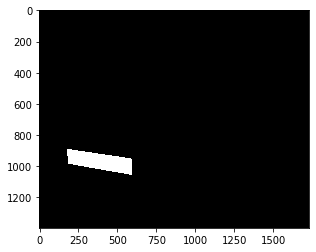

time: 912 ms


In [15]:
plt.imshow(img[...,::-1])
plt.imshow(mask[...,::-1])

In [8]:
# check data
from segmentation.dataset import SegmentationDataset
#
dataset = SegmentationDataset(data_path, config_file=train_seg_file)
print(len(dataset))
image, mask = dataset[0]
print(image.shape)
print(mask.shape)
print(np.max(mask))

25632
(3, 1396, 1733)
(1396, 1733)
1.0
time: 1.02 s


In [9]:
from tqdm import tqdm

mask_means = []
for image, mask in tqdm((dataset[i] for i in range(1000))):
    mask_means.append(mask.mean())

1000it [00:42, 23.30it/s]


time: 43 s


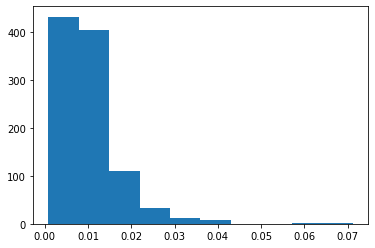

0.01004054 0.008583984 0.07112956
time: 233 ms


In [11]:
plt.hist(mask_means)
plt.show()
print(np.mean(mask_means), np.median(mask_means), np.max(mask_means))

In [24]:
# generate ocr dataset
if not os.path.exists(train_rec_file):
    with open(train_file) as rf:
        data = json.load(rf)

    new_data = []
    for i, elem in enumerate(data):
        #if i % 100 == 0:
        #    print (i, len(data))
        img_path = os.path.join(data_path, elem['file'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        for j, true_box in enumerate(elem['nums']):
            base, ext = os.path.splitext(elem['file'])
            addon = base + '.box' + str(j) + ext
            crop_name = os.path.join(data_path, addon)

            box = true_box['box']
            x_box = [w[0] for w in box]
            y_box = [w[1] for w in box]
            x1, x2 = max(0, min(x_box)), max(x_box)
            y1, y2 = max(0, min(y_box)), max(y_box)
            crop = img[y1: y2, x1: x2, :] #  TODO: you can normalize bounding box to make the OCR task easier
            cv2.imwrite(crop_name, crop)

            new_data.append(dict(file=addon, text=true_box['text']))
        break
    with open(train_rec_file, 'w') as wf:
         json.dump(new_data, wf)

In [15]:
import recognition
sys.path.insert(0, recognition.__path__[0])
from recognition.dataset import RecognitionDataset
train_dataset = RecognitionDataset(data_path, train_rec_file)
print('Train dataset: {}'.format(len(train_dataset)))
print(train_dataset[0]['image'].shape, train_dataset[0]['text'])

Train dataset: 25300
(167, 418, 3) B060BB125


In [17]:
import torch
from recognition.model import RecognitionModel
model = RecognitionModel()
model.eval()
np.random.seed(0)
inputs = torch.Tensor(np.random.normal(size=(11, 3, 32, 320)))
outputs = model.forward(inputs, decode=True)
print(outputs)

['HOHMH9Y9M9Y9H98H', 'HOHME8H8EH', 'HO8EHMHYMY98H', 'HOEHMHYEMP8', 'HO8HMHEYEY98E8', '8OHM8EYEMPYH98', '8O8H2MHYEYP8H', '8EH2MHEYEM4P9H9898', 'HO8H2MHEYEMEY8', 'HOHMEPH8EH', 'HOHMHYM4P8H']
